In [1]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 11.0 MB/s eta 0:00:00


In [73]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [60]:
df = pd.read_csv('df_result_1.csv')

In [61]:
df = df[df['ZOI_drug_NP'] > 0]

In [62]:
df_features = df.drop(['ZOI_drug_NP'], axis=1)
df_target = df[['ZOI_drug_NP']]

In [63]:
X = df_features.values
y = np.vstack(df_target.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [64]:
X_train_tensor = torch.tensor(X_train).float()
X_test_tensor = torch.tensor(X_test).float()

y_train_tensor = torch.tensor(y_train).float()
y_test_tensor = torch.tensor(y_test).float()

In [65]:
X_train_tensor.size()

torch.Size([427, 18])

In [83]:
model = nn.Sequential(nn.Linear(18, 15),
                      nn.ELU(),
                      nn.Linear(15, 7),
                      nn.ELU(),
                      nn.Linear(7, 1))

In [84]:
state = torch.load('state (1).pt')

optimizer = torch.optim.SGD(model.parameters(),lr=1)

model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer_state'])

In [85]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")


model.to(gpu)

X_train_tensor =  X_train_tensor.to(gpu)
y_train_tensor =  y_train_tensor.to(gpu)

X_test_tensor = X_test_tensor.to(gpu)
y_test_tensor = y_test_tensor.to(gpu)

In [80]:
loss = nn.MSELoss()

# С аргументами оптимизатора тоже надо поиграться, а еще лучше выбрать другой
optimizer = torch.optim.SGD(model.parameters(), lr=10e-5, momentum=0.5)
#optimizer = torch.optim.Adam(hard_model_3.parameters(), lr=10e-101)

In [86]:
def fit(model, X,Y, batch_size=32, train=True):
    model.train(train)
    sumL, sumA, numB = 0, 0, int( len(X)/batch_size )

    for i in range(0, numB*batch_size, batch_size):
        xb = X[i: i+batch_size]
        yb = Y[i: i+batch_size]

        y = model(xb)
        L = loss(y, yb)

        if train:
            optimizer.zero_grad()
            L.backward()
            optimizer.step()

        sumL += L.item()
        sumA += (y.round() == yb).float().mean()

    return sumL/numB

In [87]:
epochs = 10000

loss_train_lst = []
loss_test_lst = []
R2Score_lst = []
R2Score_test_lst = []

metric = R2Score()
metric_test = R2Score()


print( "before:      loss: %.4f" %  fit(model, X_train_tensor, y_train_tensor, train=False) )
for epoch in range(epochs):
    L = fit(model, X_train_tensor, y_train_tensor)

    metric.update(model(X_train_tensor), y_train_tensor)
    metric_test.update(model(X_test_tensor), y_test_tensor)

    R2 = metric.compute()
    R2_test = metric_test.compute()

    loss_train_lst.append(L)
    loss_test_lst.append(loss(model(X_test_tensor), y_test_tensor).detach())
    R2Score_lst.append(R2)
    R2Score_test_lst.append(R2_test)

    if epoch % 100 == 0 or epoch == 0:
      print(f'epoch: {epoch}, RMSE: {np.sqrt(L)}, R2Score: {R2:.4f}, R2Score_test: {R2_test:.4f}')

before:      loss: 62.3681
epoch: 0, RMSE: 6.951085298386443, R2Score: 0.5514, R2Score_test: 0.7328
epoch: 100, RMSE: 5.787629035465716, R2Score: 0.6177, R2Score_test: 0.7389
epoch: 200, RMSE: 5.726061578596246, R2Score: 0.6321, R2Score_test: 0.7365
epoch: 300, RMSE: 5.614189741354711, R2Score: 0.6398, R2Score_test: 0.7404
epoch: 400, RMSE: 5.496093733315522, R2Score: 0.6471, R2Score_test: 0.7464
epoch: 500, RMSE: 5.748751871654649, R2Score: 0.6523, R2Score_test: 0.7526
epoch: 600, RMSE: 5.551043427685016, R2Score: 0.6563, R2Score_test: 0.7570
epoch: 700, RMSE: 5.484590147046587, R2Score: 0.6582, R2Score_test: 0.7593
epoch: 800, RMSE: 5.549029003757771, R2Score: 0.6601, R2Score_test: 0.7615
epoch: 900, RMSE: 5.89279848298847, R2Score: 0.6618, R2Score_test: 0.7631
epoch: 1000, RMSE: 5.466179554256571, R2Score: 0.6635, R2Score_test: 0.7645
epoch: 1100, RMSE: 5.548962022945832, R2Score: 0.6651, R2Score_test: 0.7662
epoch: 1200, RMSE: 5.56595031765538, R2Score: 0.6666, R2Score_test: 0.7680

KeyboardInterrupt: ignored

Text(0, 0.5, 'Predict_target')

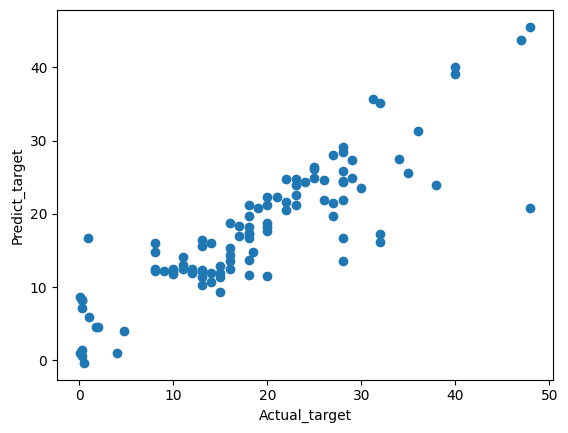

In [92]:
plt.scatter(y_test_tensor.detach(), model(X_test_tensor).detach())

plt.xlabel('Actual_target')
plt.ylabel('Predict_target')